In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy
import matplotlib.pyplot as plt

In [2]:
img_dims=28
img_chan1=1
Itnt=10

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [14]:
x_train_cero=x_train[0:6000]

In [18]:
#make shure that each image contains 3 channels
x_train=numpy.expand_dims(x_train_cero, axis=3)
x_test=numpy.expand_dims(x_test, axis=3)
#x_train=(x_train/255)
#x_test=(x_test/255)

In [19]:
print("x_train_shape", x_train.shape)
print("x_test_shape", x_test.shape)

x_train_shape (6000, 28, 28, 1)
x_test_shape (10000, 28, 28, 1)


In [20]:
#buliding the generator Network
inpt_noise=Input(shape=(Itnt,))
g11=Dense(256, activation="relu")(inpt_noise)
g12=BatchNormalization()(g11)
g13=Dense(512, activation="relu")(g12)
g14=BatchNormalization()(g13)
g15=Dense(1024, activation="relu")(g14)
g16=BatchNormalization()(g15)
g17=Dropout(0.5)(g16)
g18=Dense(img_dims*img_dims*img_chan1, activation="tanh")(g17)
g19=Reshape((img_dims, img_dims, img_chan1))(g18)
generator=Model(inpt_noise, g19)
gnrtr_img=generator(inpt_noise)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096  

In [21]:
#buliding the discriminator 
inpt_img=Input(shape=(img_dims, img_dims, img_chan1))
d11=Flatten()(inpt_img)
d12=Dropout(0.5)(d11)
d13=Dense(512, activation="relu")(d12)
d14=Dense(256, activation="relu")(d13)
d15=Dense(1, activation="sigmoid")(d14)
discriminator=Model(inpt_img, d15)
validity=discriminator(gnrtr_img)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________________

In [152]:
#any optimizer can be userd
#optimizer=RMSporp(0.0005)
optimizer=Adam(0.0002, 0.5)

#compiling the discriminator
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
discriminator.trainable=False #this will freeze the discriminator in gen_dis
gen_dis=Model(inpt_noise, validity) #full model
gen_dis.compile(loss="binary_crossentropy", optimizer=optimizer)

In [154]:
epochs=1000
batch_size=4
sample_interval=40 #for generating samples

#target vectors
valid=numpy.ones((batch_size, 1))
fake=numpy.zeros((batch_size, 1))
samp_imgs={}
dloss=[]
gloss=[]
dacc=[]

0 [D loss: 8.965624, acc: 25.00%] [G loss: 0.914621]
40 [D loss: 0.298366, acc: 100.00%] [G loss: 0.890704]
80 [D loss: 0.194225, acc: 100.00%] [G loss: 1.372436]
120 [D loss: 0.084579, acc: 100.00%] [G loss: 1.204422]
160 [D loss: 0.057131, acc: 100.00%] [G loss: 1.655845]
200 [D loss: 0.033987, acc: 100.00%] [G loss: 1.307439]
240 [D loss: 0.047268, acc: 100.00%] [G loss: 1.594874]
280 [D loss: 0.028053, acc: 100.00%] [G loss: 1.498340]
320 [D loss: 0.179304, acc: 87.50%] [G loss: 1.266994]
360 [D loss: 0.297755, acc: 75.00%] [G loss: 1.660100]
400 [D loss: 0.211441, acc: 75.00%] [G loss: 0.967661]
440 [D loss: 0.153164, acc: 100.00%] [G loss: 1.159477]
480 [D loss: 0.275289, acc: 100.00%] [G loss: 0.870700]
520 [D loss: 0.482147, acc: 62.50%] [G loss: 1.348064]
560 [D loss: 0.421044, acc: 75.00%] [G loss: 1.102668]
600 [D loss: 0.578092, acc: 62.50%] [G loss: 0.537376]
640 [D loss: 0.480023, acc: 75.00%] [G loss: 0.685318]
680 [D loss: 0.522587, acc: 62.50%] [G loss: 0.352254]
720 [

In [ ]:
#create a loop which will train in batches: manually for each epoch
for epoch in range(epochs):
    #train the discriminator first
    #batch of valid images
    idx=numpy.random.randint(0, x_train.shape[0], batch_size)
    imgs=x_train[idx]

    #noise patch to generate fake images
    noise=numpy.random.uniform(0, 1, (batch_size, Itnt))
    gen_images=generator.predict(noise)

    #gradient descent on the batch
    d_loss_real=discriminator.train_on_batch(imgs, valid)
    d_loss_fake=discriminator.train_on_batch(gen_images, fake)
    d_loss=0.5*numpy.add(d_loss_real, d_loss_fake)

    #next we will train the generator with discriminator frozen
    #noise batch to generate fake images
    noise=numpy.random.uniform(0, 1, (batch_size, Itnt))

    #gradient descent on batch
    g_loss=gen_dis.train_on_batch(noise, fake)

    #save performance
    dloss.append(d_loss[0])
    dacc.append(d_loss[1])
    gloss.append(g_loss)

    #print performance every sampling interval
    if epoch % sample_interval == 0:
        print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    noise=numpy.random.uniform(0, 1, (2, Itnt))
    gen_imgs=generator.predict(noise)
    samp_imgs[epoch]=gen_imgs


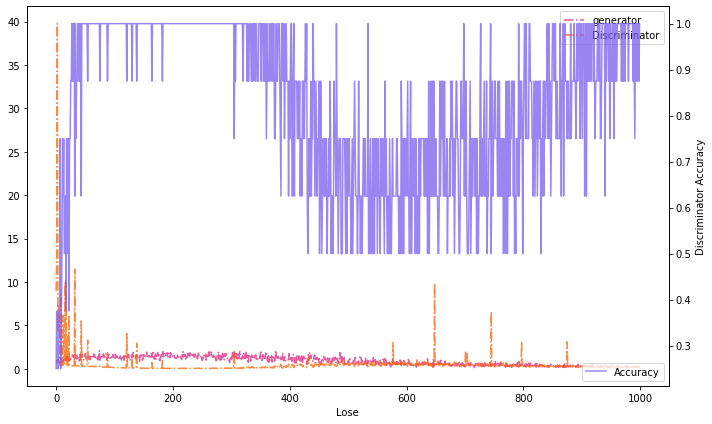

In [156]:
fig, ax1=plt.subplots(figsize=(10,6))
ax1.set_xlabel("Epoch")
ax1.set_xlabel("Lose")
ax1.plot(range(epochs), gloss, "-.", color="#dc267f", alpha=0.75, label="generator")
ax1.plot(range(epochs), dloss, "-.", color="#fe6100", alpha=0.75, label="Discriminator")
ax1.legend(loc=1)
ax2=ax1.twinx()
ax2.set_ylabel("Discriminator Accuracy")
ax2.plot(range(epochs), dacc, color="#785ef0", alpha=0.75, label="Accuracy")
ax2.legend(loc=4)
fig.tight_layout()
plt.show()

In [ ]:
fig.axs=plt.subplots(6, 10, figsize=(10, 7, 5))
cnt=sample_interval
for i in range(6):
    img=samp_imgs